In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip install librosa scikit-learn tensorflow==2.12.0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 1398, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 466, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 466, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 463, 32)       8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 154, 32)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 154, 32)       0

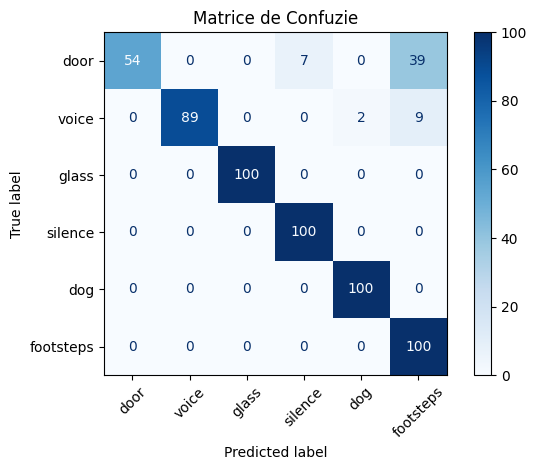


Raport pe clase:

              precision    recall  f1-score   support

        door       1.00      0.54      0.70       100
       voice       1.00      0.89      0.94       100
       glass       1.00      1.00      1.00       100
     silence       0.93      1.00      0.97       100
         dog       0.98      1.00      0.99       100
   footsteps       0.68      1.00      0.81       100

    accuracy                           0.91       600
   macro avg       0.93      0.90      0.90       600
weighted avg       0.93      0.91      0.90       600


📁 Predicțiile au fost salvate în: /content/drive/MyDrive/house_sounds/predictii_model.csv


In [39]:
import os
import numpy as np
import tensorflow as tf
import librosa
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
from sklearn.preprocessing import label_binarize

BATCH_SIZE = 4
TARGET_SAMPLE_RATE = 16000
DURATION = 3
N_MELS = 300
N_FFT = 1024
HOP_LENGTH = int((TARGET_SAMPLE_RATE * DURATION) / 1400)

model_path = '/content/drive/MyDrive/house_sounds/new_3c_mel_librosa_1200_1400x300_model'
labels_path = '/content/drive/MyDrive/house_sounds/3c_mel_class_1200_labels.pkl'
data_dir = '/content/drive/MyDrive/house_sounds/sound_data_1200'

folders = joblib.load(labels_path)
def load_sound(filename):
    file_path = filename
    if isinstance(filename, tf.Tensor):
        file_path = filename.numpy().decode('utf-8')
    wav, sr = librosa.load(file_path, sr=TARGET_SAMPLE_RATE)
    wav = librosa.util.fix_length(wav, size=TARGET_SAMPLE_RATE * DURATION)
    return wav

def create_spectrogram(file_path, label):
    wav = load_sound(file_path)
    mel_spectrogram = librosa.feature.melspectrogram(
        y=wav, sr=TARGET_SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT,
        hop_length=HOP_LENGTH, fmax=8000
    )
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if mel_spectrogram.shape[1] < 1400:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, 1400 - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :1400]
    mel_spectrogram = np.expand_dims(mel_spectrogram, axis=-1)
    return mel_spectrogram.astype(np.float32), label

def process_data(file_path, label):
    spectrogram, label = tf.py_function(
        func=create_spectrogram,
        inp=[file_path, label],
        Tout=(tf.float32, tf.int32)
    )
    spectrogram.set_shape([N_MELS, 1400, 1])
    label.set_shape([])
    return spectrogram, label

all_paths = []
all_labels = []

for idx, folder in enumerate(folders):
    folder_path = os.path.join(data_dir, folder)
    all_files = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path) if file_name.endswith('.mp3')]
    all_files = np.random.choice(all_files, size=100, replace=False)
    for file in all_files:
        all_paths.append(file)
        all_labels.append(idx)

file_ds = tf.data.Dataset.from_tensor_slices((all_paths, all_labels))
file_ds = file_ds.map(process_data)
file_ds = file_ds.batch(BATCH_SIZE).prefetch(8)

model = tf.keras.models.load_model(model_path)
model.summary()

y_true = []
y_pred = []
y_prob_all = []
file_names = []

for i, (X_batch, y_batch) in enumerate(file_ds):
    preds = model.predict(X_batch)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_prob_all.extend(preds)
    batch_filenames = all_paths[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
    file_names.extend(batch_filenames)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob_all = np.array(y_prob_all)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
logloss = log_loss(y_true, y_prob_all)
y_true_bin = label_binarize(y_true, classes=np.arange(len(folders)))
auc = roc_auc_score(y_true_bin, y_prob_all, average='macro', multi_class='ovr')

print(f"Acuratețe: {acc:.4f}")
print(f"Logarithmic Loss: {logloss:.4f}")
print(f"Area Under Curve: {auc:.4f}")
print(f"Precizie: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Scor F1: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=folders)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matrice de Confuzie")
plt.tight_layout()
plt.show()

print("\nRaport pe clase:\n")
print(classification_report(y_true, y_pred, target_names=folders))

results_df = pd.DataFrame({
    "file": file_names,
    "true_label": [folders[i] for i in y_true],
    "predicted_label": [folders[i] for i in y_pred]
})
csv_path = "/content/drive/MyDrive/house_sounds/predictii_model.csv"
results_df.to_csv(csv_path, index=False)
print(f"\n📁 Predicțiile au fost salvate în: {csv_path}")
